In [116]:
import pandas as pd
import seaborn as sns

In [2]:
run '~/eddata/eddata/dconn.py'

In [3]:
conn = Conn('eddata', 'dw')

/Users/pto845/.virtualenvs/ed/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [128]:
q = """
WITH act AS (
SELECT 
		school_code
		,district_code
		,school_year
		,MAX(student_count) as student_count
		,MIN(average_score) as average_score
FROM raw_data.wisedash_act_statewide act
WHERE act.agency_type = 'Public school'
		AND act.group_by = 'All Students' 
		AND act.group_by_value = 'All Students' 
		AND act.test_subject = 'Composite'
		AND (LOWER(act.test_result) = 'not benchmarked')
		AND (college_readiness != 'No Test' OR college_readiness IS NULL)
GROUP BY 1, 2, 3)
SELECT 
		* 
FROM
        staging.school_ft sft
JOIN
		act
	ON act.school_code = LPAD(sft.local_school_id::text, 4, '0')
		AND act.district_code = LPAD(sft.local_agency_id::text, 4, '0')
WHERE
        sft.location_state = 'WI'
    AND sft.school_type = 1
    AND sft.current_status = 1
ORDER BY
		sft.school_id
		,act.school_year;
"""
df = conn.execute_raw_query(q)

In [129]:
df['location_zip'] = df['location_zip'].astype(int).astype(str)

In [130]:
df.head().T

,0,1,2,3,4
school_id,1454494,1454494,1454494,1454494,1454494
nces_school_id,550001602378,550001602378,550001602378,550001602378,550001602378
local_school_id,11,11,11,11,11
local_agency_id,485,485,485,485,485
school_name,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH
phone_number,6089892525,6089892525,6089892525,6089892525,6089892525
location_address,N31024 ELLAND RD,N31024 ELLAND RD,N31024 ELLAND RD,N31024 ELLAND RD,N31024 ELLAND RD
location_city,BLAIR,BLAIR,BLAIR,BLAIR,BLAIR
location_state,WI,WI,WI,WI,WI
location_zip,54616,54616,54616,54616,54616


In [183]:
features = ['is_bie_school', 'is_tas_eligible', 'tas_provided', 'is_swp_eligible', 'swp_provided', 'is_magnet', \
            'is_charter', 'is_shared_school', 'is_virtual_school', 'is_nslp_participant', 'nslp_provision']

d = {}
for feature in features:
    d[feature] = df[feature].fillna('missing').value_counts(normalize=True).apply(lambda x: '{0:.1f}%'.format(x*100)).to_dict()

d

{'is_bie_school': {False: '100.0%'},
 'is_tas_eligible': {False: '58.2%', True: '41.8%'},
 'tas_provided': {False: '67.3%', True: '32.7%'},
 'is_swp_eligible': {False: '87.3%', True: '12.7%'},
 'swp_provided': {False: '87.3%', True: '12.7%'},
 'is_magnet': {False: '100.0%'},
 'is_charter': {False: '93.2%', True: '6.8%'},
 'is_shared_school': {False: '100.0%'},
 'is_virtual_school': {'missing': '100.0%'},
 'is_nslp_participant': {True: '100.0%'},
 'nslp_provision': {'None': '100.0%'}}

In [90]:
zip_df = pd.read_csv('/Users/pto845/Downloads/us-household-income-stats-geo-locations/kaggle_income.csv',\
                     encoding='latin1', dtype={'Zip_Code': str})

In [136]:
zip_df = pd.pivot_table(data = zip_df[(zip_df.State_ab == 'WI') & (zip_df.Mean  != 0)],
                                         index = 'Zip_Code',
                                         values = ['Mean', 'Median', 'Stdev'],
                                         aggfunc = 'mean').reset_index()\
    .rename(columns={'Zip_Code': 'location_zip', 'Median': 'median_income', 'Mean': 'mean_income'})

In [137]:
df = df.merge(z, on='location_zip', how='left')

In [138]:
df.head().T

,0,1,2,3,4
school_id,1454494,1454494,1454494,1454494,1454494
nces_school_id,550001602378,550001602378,550001602378,550001602378,550001602378
local_school_id,11,11,11,11,11
local_agency_id,485,485,485,485,485
school_name,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH,BLAIR-TAYLOR MIDDLE/HIGH
phone_number,6089892525,6089892525,6089892525,6089892525,6089892525
location_address,N31024 ELLAND RD,N31024 ELLAND RD,N31024 ELLAND RD,N31024 ELLAND RD,N31024 ELLAND RD
location_city,BLAIR,BLAIR,BLAIR,BLAIR,BLAIR
location_state,WI,WI,WI,WI,WI
location_zip,54616,54616,54616,54616,54616


Coefficients: 
 [5.30701902e-06]
Mean squared error: 4.10
Variance score: 0.07


([], <a list of 0 Text yticklabel objects>)

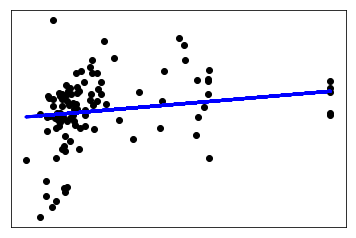

In [185]:
data = df[df.school_year=='2014-15'][['median_income', 'is_charter', 'average_score']].dropna(how='any')
X = data[['median_income']].values

y = data['average_score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

regr.coef_
y_hat = regr.predict(X_test)


print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_hat))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_hat))

plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_hat, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())


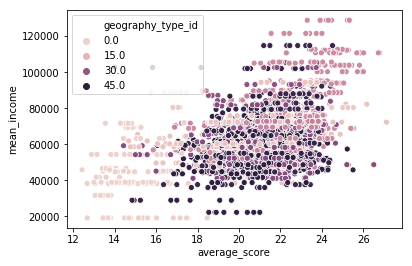

In [174]:
sns.scatterplot(x=df['average_score'], y=df['mean_income'], hue=df['geography_type_id'])